# Predicting optimal chamber size for swimming cells

---

In the pub 'Gotta catch ‘em all: Agar microchambers for high-throughput single-cell live imaging'(https://research.arcadiascience.com/pub/resource-agar-microchamber) we are interested in gaining a quantitative understanding of how confinement affects organismal biology, including cell behavior and motility. In this notebook we analyze a publicly available resource data set, the BOSO-Micro dataset (https://doi.org/10.1371/journal.pone.0252291), which contains information about cell size, shape, and behavior for 382 unicellular species/cell types of swimming prokaryotes and eukaryotes. 

Organismal size is a clear constraint on chamber size. Perhaps less obvious is the effect of an organism’s speed of movement. For example, a large organism that swims slowly would likely require a different chamber size from one that swims quickly (since the faster organism would hit the chamber boundaries more frequently).

To control for this, here we calculate the area covered/second for each organism and then estimate an appropriate chamber size for measuring open field swimming. A suggested scaling value of 200x area covered/second is used (calculated from the empirical relationship of Chlamydomonas rheinhardtii cells with 100 micron diamter chambers).

---

Load packages

In [ ]:
install.packages("devtools")
devtools::install_github("Arcadia-Science/arcadia-color-brewer")
library(ArcadiaColorBrewer)

Function to load data from the BOSO-micro dataset

In [2]:
load_boso_micro_data <- function(file) {
  # Load file
  dat <- read.csv(file)

  # Remove species without body or speed measurements
  dat <- dat[!dat$B == "-", ]
  dat <- dat[!dat$U == "-", ]

  # Calculate body length/second
  dat$body_length_second <- as.numeric(dat$U) / as.numeric(dat$B)

  # Calculate area covered per FLcoit
  dat$area_covered_second <- as.numeric(dat$body_length_second) * (as.numeric(dat$B))

  # Calculate 'minimum diameter' for size
  # Multiply area covered by 200
  y <- dat$area_covered_second * 200

  # Extract radius
  r <- sqrt(y) / pi

  # Calculate diameter
  d <- round(r * 2)

  # Add
  dat$minimum_chamber_diameter <- d

  # Return
  return(dat)
}

Download the BOSO-micro database

In [3]:
# Download
system('wget https://github.com/marcos-fvr/BOSO-micro/archive/refs/tags/v1.0.zip')

# Unzip
system('unzip v1.0.zip')

Load all BOSO-micro data

In [4]:
# Create empty list to save data into
boso_micro <- list()

# List directories in BOSO-micro
dirs <- list.files("BOSO-micro-1.0/")

# Select just directories with data
dirs <- dirs[1:6]

# Loop through and load
for (i in 1:length(dirs)) {
    
  # Move to data directory
  setwd(paste("BOSO-micro-1.0/", dirs[[i]], sep = ""))
    
  # List files
  files <- list.files()

  # Load
  boso_micro[[as.character(dirs[i])]] <- load_boso_micro_data(files[grep(".csv", files)])
    
  # Got back to parent directory
  setwd("../../")
}

Plot

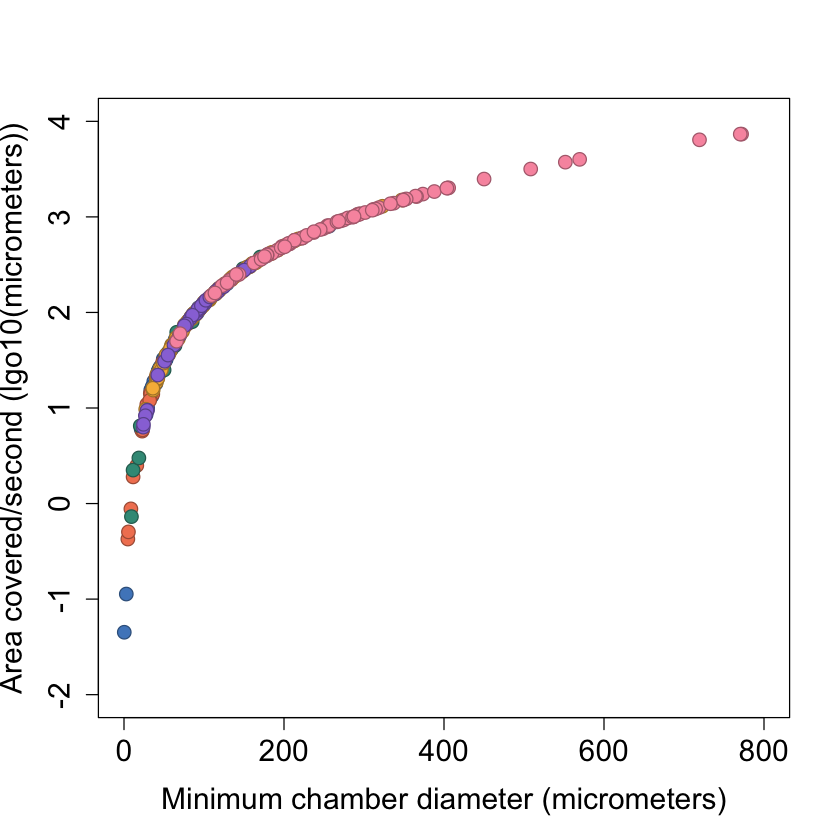

In [5]:
# Get colors
cols <- ArcadiaColorBrewer::arcadia.pal(6, name = "Accent")

# Plot
plot(
  jitter(boso_micro[[1]]$minimum_chamber_diameter, 10),
  log10(boso_micro[[1]]$area_covered_second),
  cex = 1.5,
  pch = 21,
  bg = cols[1],
  col = darken_color(cols[1]),
  cex.lab = 1.5,
  cex.axis = 1.5,
  ylim = c(-2, 4),
  xlim = c(0, 800),
  xlab = "Minimum chamber diameter (micrometers)",
  ylab = "Area covered/second (lgo10(micrometers))"
)
for (i in 2:length(boso_micro)) {
  points(
    jitter(boso_micro[[i]]$minimum_chamber_diameter, 10),
    log10(boso_micro[[i]]$area_covered_second),
    cex = 1.5,
    pch = 21,
    bg = cols[i],
    col = darken_color(cols[i])
  )
}

Clean up

In [8]:
system('rm -r BOSO-micro-1.0/')
system('rm v1.0.zip')